In [1]:
import gym

import numpy as np
import random
from collections import namedtuple, deque
import pandas as pd
import matplotlib.pyplot as plt

from Agent import Agent

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
sum_gradients = {}
def reset_avg_gradients():
    for name, param in agent.local_model.to(device).named_parameters():
        sum_gradients[name] = torch.zeros(size=param.size()).to(device)

In [3]:
def calc_avg_gradients(client):
    for i in range(len(client)):
        gradients = {}
        for name, param in client[i].local_model.to(device).named_parameters():
            gradients[name] = param.grad
            sum_gradients[name] += (gradients[name] / no_of_clients)
        #print("gradient = ",gradients)
    #print("sum_gradients = ",sum_gradients)


In [4]:
def cal_best_gradients(client):
    idx = np.argmax([np.mean(client[i].scores_window) for i in range(len(client))])
    #print([np.mean(client[i].scores_window) for i in range(len(client))])
    #print("idx = ",idx)
    for name, param in client[idx].local_model.to(device).named_parameters():
        sum_gradients[name] = param.grad

In [5]:
def set_new_gradients(sum_gradients,agent):
    gradients = {}
    for name, param in agent.local_model.to(device).named_parameters():
        param.grad = sum_gradients[name]


In [6]:
def get_gradients(agent):
    gradients = {}
    for name, param in agent.local_model.to(device).named_parameters():
        gradients[name] = param.grad


In [7]:
environment = 'LunarLander-v2'
env = gym.make(environment)
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
no_of_clients = 5
clients = []
fed_rounds = 3
episode_per_fed = 4
grad_update_method = 'global_buf' #simple_avg, best_score
max_steps=1000          #max number of steps in an episode
       

for i in range(no_of_clients):
    agent = Agent(state_size=state_size, action_size=action_size, seed=i)
    clients.append(agent)
    
for i in range(no_of_clients):
    print(clients[i])

State shape:  8
Number of actions:  4


In [8]:
def dqn(agent,clientID,fed_round):
      # last 100 scores
    #self.eps = self.eps_start                    # initialize epsilon
    for i_episode in range(1, episode_per_fed+1):
        state = env.reset()
        score = 0
        for t in range(max_steps):
            action = agent.act(state, agent.eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        agent.scores_window.append(score)       # save most recent score
        agent.scores.append(score)              # save most recent score
        agent.eps = max(agent.eps_end, agent.eps_decay*agent.eps) # decrease epsilon
        print('\rfed round {} client {} Episode {}\tAverage Score: {:.2f}'.format(fed_round,clientID,i_episode, np.mean(agent.scores_window)), end="")
        if (episode_per_fed*fed_round + i_episode) % 100 == 0:
            print('\rfed round {} client {} Episode {}\tAverage Score: {:.2f}'.format(fed_round,clientID,i_episode, np.mean(agent.scores_window)))
#     print("memory",len(agent.memory))
#     for j in range(len(agent.memory)):
#         print("\n")
#         print(agent.memory.gb_memory[j])
    agent.eps = agent.eps*0.94
    #print(" buffer size = ",len(agent.memory.gb_memory))


In [9]:
for f in range(fed_rounds):
    reset_avg_gradients()
    for i in range(no_of_clients):
        dqn(clients[i],i,f)
    
    if grad_update_method == 'simple_avg': 
        calc_avg_gradients(clients)
    elif grad_update_method == 'best_score':
        cal_best_gradients(clients)
    else:
        x = 10 #do nothing as of now
    for i in range(no_of_clients):
        set_new_gradients(sum_gradients,clients[i])
    

fed round 0 client 0 Episode 4	Average Score: -206.91 buffer size =  360
fed round 0 client 1 Episode 4	Average Score: -281.49 buffer size =  732
fed round 0 client 2 Episode 4	Average Score: -182.86 buffer size =  1066
fed round 0 client 3 Episode 4	Average Score: -136.35 buffer size =  1414
fed round 0 client 4 Episode 4	Average Score: -185.69 buffer size =  1843
fed round 1 client 0 Episode 4	Average Score: -232.35 buffer size =  2218
fed round 1 client 1 Episode 4	Average Score: -292.11 buffer size =  2638
fed round 1 client 2 Episode 4	Average Score: -185.91 buffer size =  3008
fed round 1 client 3 Episode 4	Average Score: -184.87 buffer size =  3396
fed round 1 client 4 Episode 4	Average Score: -158.35 buffer size =  3821
fed round 2 client 0 Episode 4	Average Score: -213.62 buffer size =  4231
fed round 2 client 1 Episode 4	Average Score: -235.90 buffer size =  4608
fed round 2 client 2 Episode 4	Average Score: -191.03 buffer size =  5034
fed round 2 client 3 Episode 4	Average S

In [10]:
########################playing the lunar lander######################################
# def final_play():
#     for e in range(4):
#         state = env.reset()
#         done = False
#         while not done:
#             env.render()
#             action = agent.act(state)
#             next_state, reward, done, _ = env.step(action)
#             agent.step(state, action, reward, next_state, done)
#             state = next_state
#final_play()
#env.close()

In [11]:
def moving_average(vec,window_size):    

    numbers_series = pd.Series(vec)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    averaged_v = moving_averages_list[window_size - 1:]
    return(averaged_v)


In [12]:
def plot_graphs(values1,values2,xstring,ystring,title): 
  
    y1 = values1
    y2 = values2
    x1 = [i for i in range(0,len(values1))]
    x2 = [i for i in range(0,len(values2))]
    plt.plot(x1,y1)
    plt.plot(x2,y2,linewidth = 4)
    plt.xlabel(xstring) # naming the x axis      
    plt.ylabel(ystring) # naming the y axis
    plt.title(title) 

    plt.show()


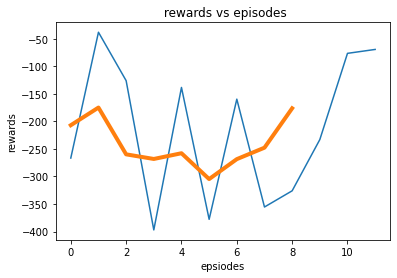

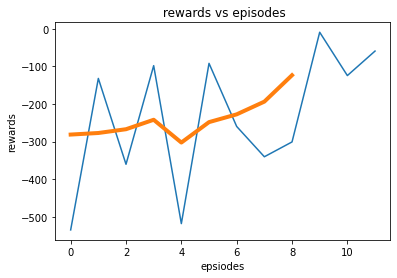

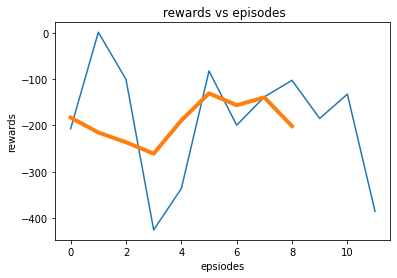

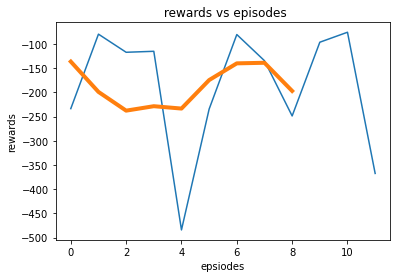

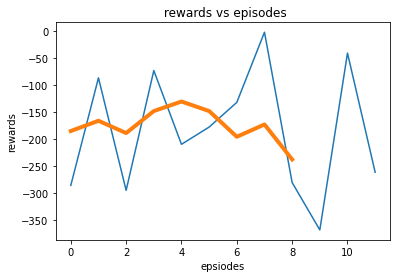

In [13]:
window_size = 4
averaged_scr = []
for i in range(no_of_clients):   
    averaged_ = moving_average(clients[i].scores,window_size)
    #averaged_scr.append(averaged_)
    plot_graphs(clients[i].scores,averaged_,'epsiodes','rewards',' rewards vs episodes')
    #print(averaged_[0:20])
    averaged_scr.append(averaged_)
avg_score = averaged_

In [14]:
df = pd.DataFrame(avg_score)
df.to_csv('trial1.csv')

df2 = pd.DataFrame(averaged_scr)
df2 = df2.transpose()
df2.to_csv('concurrentRL_all5clients.csv')
print(df2)

            0           1           2           3           4
0 -206.906233 -281.491949 -182.861439 -136.351465 -185.691154
1 -174.844515 -277.294434 -215.206796 -198.989808 -166.678676
2 -259.807852 -267.269733 -236.149792 -237.675703 -189.461646
3 -268.206913 -242.104518 -260.879308 -228.518754 -148.752520
4 -257.800674 -302.724856 -188.968169 -233.381428 -131.013530
5 -304.741473 -248.382947 -130.491982 -174.517067 -148.703841
6 -268.523625 -227.683619 -156.142359 -139.994818 -196.303674
7 -247.720216 -193.821840 -139.359294 -138.805877 -173.503093
8 -176.161994 -123.492264 -201.252914 -197.023518 -238.287315
